In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) 
# will list the files in the input directory

import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import matplotlib.pyplot as plt

In [2]:
#Read Data
data = pd.read_csv('data.csv')

#Randomly Smaple data, ratio is 100%
data = data.sample(frac = 1)

#Show Data
data.head()
for i in range(0,data.shape[0]-1):
    if(data.Body.isnull()[i]):
        data.Body[i] = data.Headline[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [3]:
# (Create a new column called Length that record every Headline length)
data['Length'] = [len(headline) for headline in data['Headline']]
data.head()

,URLs,Headline,Body,Label,Length
3739,http://beforeitsnews.com/sports/2017/09/jets-v...,Jets vs. Jaguars Week 4 Preview,Jets vs. Jaguars Week 4 Preview\n(Before It's ...,0,31
2326,https://www.reuters.com/article/us-usa-trump-d...,Trump nominates White House aide for homeland ...,White House Chief of Staff John Kelly (R) walk...,1,59
2003,https://www.activistpost.com/2017/09/saudi-ara...,"Accused of War Crimes, Saudi Arabia Investigat...",By Carey Wedler\nAmid international calls for ...,0,82
491,http://beforeitsnews.com/u-s-politics/2017/10/...,SNL: Michael Che Calls Trump “You B*tch” Over ...,"Vietnam Is in Great Danger, You Must Publish a...",0,66
1207,http://beforeitsnews.com/u-s-politics/2017/10/...,Teen Suspended For Sitting During Pledge Of Al...,A Potato Battery Can Light up a Room for Over ...,0,54


In [4]:
detail = data['Length'].describe()
print(detail)

count    4009.000000
mean       60.104016
std        22.660900
min         6.000000
25%        48.000000
50%        60.000000
75%        69.000000
max       653.000000
Name: Length, dtype: float64


In [5]:
# Get all true news
fliter = data['Label'] == 1
pos = data[fliter]
print('Positive：', len(pos))

# Get all fake news
fliter = data['Label'] == 0
neg = data[fliter]
print('Negative：', len(neg))

the_mean = min(len(pos), len(neg))
print("==============================================")

#Random Shuffle
p_data = pos.sample(n = the_mean)
print('Mean0：', len(p_data))

#Random Shuffle
n_data = neg.sample(n = the_mean)
print('Mean1：', len(n_data))

Positive： 1872
Negative： 2137
Mean0： 1872
Mean1： 1872


In [6]:
test_split = 0.2
train_split = 1 - test_split

# (20% for Testing Data, others 80% for Training Data)
p_train_data = p_data.sample(frac = train_split)
p_test_data = p_data.drop(p_train_data.index)

n_train_data = n_data.sample(frac = train_split)
n_test_data = n_data.drop(n_train_data.index)


#Combined fake news and true news
train_data = pd.concat([p_train_data, n_train_data])
test_data = pd.concat([p_test_data, n_test_data])

#Random Shuffle
train_data = train_data.sample(frac = 1)
test_data = test_data.sample(frac = 1)

x_train_data = train_data['Headline'].fillna('')
y_train_data = train_data['Label']
x_test_data = test_data['Headline'].fillna('')
y_test_data = test_data['Label']

print('Train Data x Feature：', len(x_train_data))
print('Train Data y Label：', len(y_train_data))
print('Test Data x Feature：', len(x_test_data))
print('Test Data y Label：', len(y_test_data))

Train Data x Feature： 2996
Train Data y Label： 2996
Test Data x Feature： 748
Test Data y Label： 748


In [7]:
%tensorflow_version 1.x
import tensorflow as tf
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or 

In [0]:
#Create a token dictionary
token_num = 4000 

#Get a fix length, we chose the mean of the Headline length
data_length = int(detail['mean'])  

#Word Embeding output vector dimension
output_length = 32 

dropout = 0.2
lstm_dim = 256

In [0]:
token = Tokenizer(num_words = token_num, filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
token.fit_on_texts(x_train_data)

In [0]:
x_train_seq = token.texts_to_sequences(x_train_data)
x_test_seq = token.texts_to_sequences(x_test_data)

In [0]:
x_train = sequence.pad_sequences(x_train_seq, maxlen = data_length)
x_test = sequence.pad_sequences(x_test_seq, maxlen = data_length)

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, TimeDistributed
from keras.callbacks import EarlyStopping


In [0]:
from tensorflow.python.ops import control_flow_ops

orig_while_loop = control_flow_ops.while_loop

def patched_while_loop(*args, **kwargs):
    kwargs.pop("maximum_iterations", None)  # Ignore.
    return orig_while_loop(*args, **kwargs)


control_flow_ops.while_loop = patched_while_loop

In [19]:
model = Sequential()
model.add(Embedding(output_dim = output_length, 
                    input_dim = token_num, 
                    input_length = data_length))
model.add(Dropout(dropout))

# using BLSTM (this will be better than LSTM, Avg acc is around 0.85
model.add(Bidirectional(LSTM(lstm_dim), merge_mode = 'sum'))
model.add(Dropout(dropout))

# using LSTM, Avg acc is around 0.84
# model.add(LSTM(lstm_dim))
# model.add(Dropout(dropout))

model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(dropout))

model.add(Dense(units = 1, activation = 'sigmoid'))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 60, 32)            128000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 32)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               591872    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [0]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [0]:
es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)

In [22]:
train_history = model.fit(x = x_train,
                         y = y_train_data,
                         validation_split = 0.2,
                         epochs = 20,
                         batch_size = 100,
                         verbose = 1,
                         callbacks = [es])

Train on 2396 samples, validate on 600 samples
Epoch 1/20
2396/2396 [==============================] - 43s 18ms/step - loss: 0.6908 - acc: 0.5221 - val_loss: 0.6668 - val_acc: 0.6800
Epoch 2/20
2396/2396 [==============================] - 42s 18ms/step - loss: 0.7174 - acc: 0.5876 - val_loss: 0.6465 - val_acc: 0.6833
Epoch 3/20
2396/2396 [==============================] - 42s 18ms/step - loss: 0.5353 - acc: 0.8351 - val_loss: 0.4622 - val_acc: 0.7983
Epoch 4/20
2396/2396 [==============================] - 42s 18ms/step - loss: 0.2570 - acc: 0.8961 - val_loss: 0.3813 - val_acc: 0.8200
Epoch 5/20
2396/2396 [==============================] - 42s 18ms/step - loss: 0.1517 - acc: 0.9445 - val_loss: 0.3758 - val_acc: 0.8617
Epoch 6/20
2396/2396 [==============================] - 42s 18ms/step - loss: 0.0793 - acc: 0.9704 - val_loss: 0.4048 - val_acc: 0.8550
Epoch 7/20
2396/2396 [==============================] - 42s 17ms/step - loss: 0.0459 - acc: 0.9846 - val_loss: 0.5015 - val_acc: 0.8450
E

In [0]:
%matplotlib inline
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

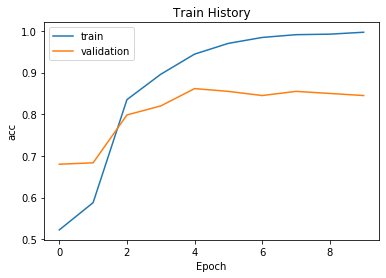

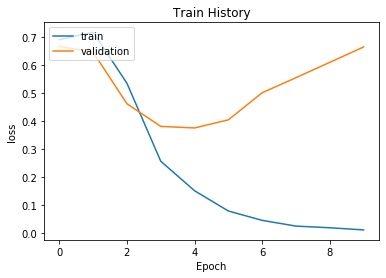

In [24]:
show_train_history(train_history, 'acc', 'val_acc')
show_train_history(train_history, 'loss', 'val_loss')

In [25]:
scores = model.evaluate(x = x_test, y = y_test_data)
scores[1]

748/748 [==============================] - 4s 6ms/step


0.8582887700534759